In [3]:
import os
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()
region = sagemaker_session.boto_session.region_name

In [5]:
# https://cs.stanford.edu/~zxie/textgen.pdf
# https://www.tensorflow.org/text/tutorials/transformer#set_up_the_tokenizer

import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU!!!!!!!!!!!!!!!!")
else:
    device = torch.device('cpu')
    print("CPU :(")

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

# !conda install keras
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequence
!pip install transformers
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments

import boto3

CPU :(
  Using cached transformers-4.30.2-py3-none-any.whl (7.2 MB)
  Using cached huggingface_hub-0.15.1-py3-none-any.whl (236 kB)
  Using cached regex-2023.6.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (770 kB)
  Using cached tokenizers-0.13.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.8 MB)
  Using cached safetensors-0.3.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
#load the dataset
#NOTE THAT SINCE THIS CORPUS IS ONLY IN LOWERCASE, YOU NEED TO FEED THE DATA AS LOWERCASES OR YOU WILL NOT GET *ACCURATE* TRANSLATIONS
client = boto3.client('s3')
df = pd.read_csv("s3://sagemaker-translations-tr-en/data.csv", delimiter = "\t", names=['turkish','english'])

In [8]:
#verify that the dataset has been loaded

print(df.columns)
print(df.head())
print(df.shape)


Index(['turkish', 'english'], dtype='object')
                                             turkish   
0  emekli üyeler kongre'nin şu sıralar çete savaş...  \
1  entellektüellik , klas , asalet veya hikaye il...   
2  hangisi olduğunu tahmin edebildiniz mi ? şirke...   
3  pek uzak yerlere seyahat edemez veya belli bir...   
4                                 heyecanlanmıştım .   

                                             english  
0  retiring members nowadays say that it 's becom...  
1  no sophistication , no class , no dignity , no...  
2                     did you guess it ? companies .  
3  you ca n't travel very far or venture too far ...  
4                                    i was excited .  
(191524, 2)


In [11]:
%%time
# tokenizer = Tokenizer(oov_token="<UNK>")

# # Fit the tokenizer on the texts
# tokenizer.fit_on_texts(df['turkish'].tolist() + df['english'].tolist())

# # Convert the turkish and english columns into sequences
# turkish_sequences = tokenizer.texts_to_sequences(df['turkish'])
# english_sequences = tokenizer.texts_to_sequences(df['english'])

# # Pad the sequences so that they are all the same length
# turkish_padded = pad_sequences(turkish_sequences, padding='post')
# english_padded = pad_sequences(english_sequences, padding='post')

# df['turkish_tokenized'] = turkish_padded.tolist()
# df['english_tokenized'] = english_padded.tolist()

# Initialize the GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2") 
tokenizer.add_special_tokens({'pad_token': '[PAD]'}, {'unknown_token': '[UNK]'}) # Add the [PAD] and [UNK] tokens to the tokenizer
tokenizer.padding_side = "right"

#tokenize_text function that tokenizes the text with a max length and padding
def tokenize_text(text):
    tokenized_text = tokenizer.encode_plus(text, padding='max_length', truncation=True, max_length=256, return_tensors="pt")
    input_ids = tokenized_text["input_ids"]
    attention_mask = tokenized_text["attention_mask"]
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    return tokens

# print(tokenizer.tokenize("Hello, my dog is cute"))
# print(tokenizer.tokenize(df['english'][0]))
# print(df['english'][:5].apply(lambda x : tokenize_text(x)))
# print(df['english'][:5]) # Tokenize a sample sentence
df['english_tokens'] = df['english'].apply(lambda x : tokenize_text(x))  # Tokenize English text
df['turkish_tokens'] = df['turkish'].apply(lambda x : tokenize_text(x))  # Tokenize Turkish text

######################################################################
#TODO: ADD <NUM> TOKEN SO THAT THE MODEL CAN KEEP THE NUMBERS THE SAME
######################################################################

CPU times: user 7min 40s, sys: 1.57 s, total: 7min 42s
Wall time: 7min 42s


In [26]:
 # Testing for NaN values using isna()
#ensure that the tokenizing is working properly
print(df.head())

                                             turkish  \
0  emekli üyeler kongre'nin şu sıralar çete savaş...   
1  entellektüellik , klas , asalet veya hikaye il...   
2  hangisi olduğunu tahmin edebildiniz mi ? şirke...   
3  pek uzak yerlere seyahat edemez veya belli bir...   
4                                 heyecanlanmıştım .   

                                             english  \
0  retiring members nowadays say that it 's becom...   
1  no sophistication , no class , no dignity , no...   
2                     did you guess it ? companies .   
3  you ca n't travel very far or venture too far ...   
4                                    i was excited .   

                                      english_tokens  \
0  [ret, iring, Ġmembers, Ġnowadays, Ġsay, Ġthat,...   
1  [no, Ġsophistication, Ġ,, Ġno, Ġclass, Ġ,, Ġno...   
2  [did, Ġyou, Ġguess, Ġit, Ġ?, Ġcompanies, Ġ., [...   
3  [you, Ġca, Ġn, 't, Ġtravel, Ġvery, Ġfar, Ġor, ...   
4  [i, Ġwas, Ġexcited, Ġ., [PAD], [PAD], [PAD]

In [13]:
# Save the vocabulary to a file
vocab_file = "./gpt2vocab"
tokenizer.save_vocabulary(vocab_file)

Vocabulary path (./gpt2vocab) should be a directory


['[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
['e', 'ÄŁ', 'er', 'Ġv', 'ars', 'a', 'Ġ,', 'Ġ', 'iz', 'ley', 'ic', 'iler', 'Ġar', 'as', 'Ä±']


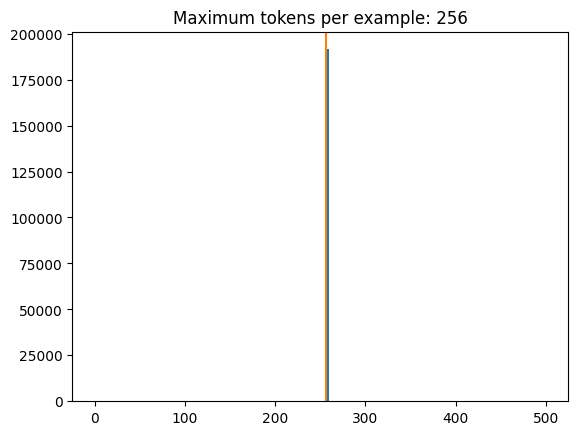

In [33]:
# The following function takes batches of text as input, and converts them to a format suitable for training.

#     It trims each to be no longer than MAX_TOKENS.
#     It splits the target (English) tokens into inputs and labels. These are shifted by one step so that at each input location the label is the id of the next token.
#     It converts the RaggedTensors to padded dense Tensors.
#     It returns an (inputs, labels) pair.

# MAX_TOKENS = 128

# def prepare_batch(tr):
#     print("tr4:",tr[:2][:, :2])
#     print("tr4ty". type(tr[:4]))
#     # print("tr44:", tr[:4, :4])
#     return tr[:4][:4]


# has_nans = df['turkish_tokens'].isna().any()
# print(has_nans)
# has_nans = prepare_batch(df['turkish_tokens']).isna().any()
# print(has_nans)
# # print(prepare_batch(df['turkish_tokens']))

print(df['turkish_tokens'][5138][240:254])
print(df['turkish_tokens'][1000][:15])

lengths = []

for sample in df['turkish_tokens']:
    try:
        lengths.append(len(sample))
    except:
        print(sample)
    
plt.hist(lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');


In [29]:
#create the training, validation and testing datasets
train = df.sample(frac=0.9, random_state=0)
test = df.drop(train.index)
validation = test.sample(frac=0.5, random_state=0)
test = test.drop(validation.index)

#create a pandas dataframe for each of the train, validation and test datasets
train_df = pd.DataFrame({
    'turkish': train['turkish_tokens'].tolist(),
    'english': train['english_tokens'].tolist()
})
validation_df = pd.DataFrame({
    'turkish': validation['turkish_tokens'].tolist(),
    'english': validation['english_tokens'].tolist()
})
test_df = pd.DataFrame({
    'turkish': test['turkish_tokens'].tolist(),
    'english': test['english_tokens'].tolist()
})


In [30]:
print(train_df.shape)
print(validation_df.shape)
print(test_df.shape)

(172372, 2)
(9576, 2)
(9576, 2)
